# __K-Means Clustering: Movies Recommender__

In this lab we will be using Netflix movie reviews to group customers by their preferences with the ultimate goal of building a movie recommender for users. We will use the K-Means clustering algorithm to learn similarities between customer likes and dislikes.

We will explore both genre and movie titles as input features.

## Exploring the datasets (EDA)
---

The dataset we are going to use in this lab comes from the [MovieLens](https://movielens.org/) project, a non-commercial movie recommendation. They have several available datasets for different purposes, but in this lab we are going to use the one called ["latest"](https://grouplens.org/datasets/movielens/latest/), and the [small version](https://files.grouplens.org/datasets/movielens/ml-latest-small.zip) of it (1MB). 

In [1]:
# Import Libraries
import pandas as pd
# Import the movies dataset
movies = pd.read_csv('movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


The movies dataframe contains the variables *movieId*, *title* and *genres*. The list of genres that apply to a particular movie appear in a long string and are separated by the vertical bar (`|`) symbol.

Now let's look at the movie ratings dataset:

In [2]:
# Import the ratings dataset
ratings = pd.read_csv('ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Each movie (labelled *movieId*) has a *rating* and *timestamp* for each user, and each user has a unique *userId*. Of course, each user will have rated only a fraction of the movies listed in the movies dataset.

We will not be using *timestamp*, so let's drop that variable from the dataframe:

In [3]:
ratings.drop('timestamp',axis=1,inplace=True)
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [4]:
# Print out the number of users, movie titles and ratings
print('The movies dataset contains',len(movies),'movies.')
print('The ratings dataset contains', len(ratings["userId"].unique()), 'users,',len(ratings['movieId'].unique()),'movies and',len(ratings),'ratings.')

The movies dataset contains 9742 movies.
The ratings dataset contains 610 users, 9724 movies and 100836 ratings.


In [5]:
print('This is an average of', round(len(ratings)/len(ratings["userId"].unique())), 'ratings per user.')

This is an average of 165 ratings per user.


In [6]:
# Get unique values for ratings
print('Users can rate movies as:',sorted(ratings["rating"].unique()))

Users can rate movies as: [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


Plot a histogram of the distribution of ratings:

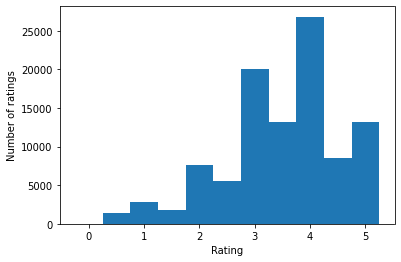

In [7]:
import matplotlib.pyplot as plt
binbreaks = [-0.25, 0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25]
plt.hist(ratings.rating, bins=binbreaks)
plt.xlabel('Rating')
plt.ylabel('Number of ratings')
plt.show()

We can see that the distribution of ratings is left(negative)-skewed. Most rated movies get a rating of around 4 and few users rate movies below a 3. 

Above we calculated the average number of ratings per user, but it would be helpful to see the distribution of user ratings. Plot a bar chart showing the number of movies rated by each user. Is this distribution symmetric or skewed?

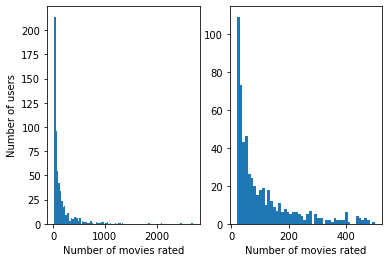

In [8]:
ratings_by_user = ratings["userId"].value_counts()
fig, (ax1, ax2) = plt.subplots(1, 2)
# Plot all the data
ax1.hist(ratings_by_user,bins=100)
ax1.set_xlabel('Number of movies rated')
ax1.set_ylabel('Number of users')
# Zoom in 
ax2.hist(ratings_by_user,bins=50,range=(min(ratings_by_user),500))
ax2.set_xlabel('Number of movies rated')
plt.show()

The distribution of the number of movies rated by users is right(positive)-skewed. Most users rate only around 20 movies, with a few rating more than 1000 movies. 

Now let's print out all the genres in the movies dataset:

In [9]:
genre_names = [] # List for all genres
for i in range(0,len(movies)): # Loop through movies dataframe
    genres_unique = movies.genres[i].split('|') # Split the genres string for that movie into individual genres
    for genre in genres_unique:
        if genre not in genre_names: # Add the genre to the list of genres if not already in the list
            genre_names.append(genre)
print('There are',len(genre_names),'genres.')
print('The genres are:',genre_names)

There are 20 genres.
The genres are: ['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'Mystery', 'Sci-Fi', 'War', 'Musical', 'Documentary', 'IMAX', 'Western', 'Film-Noir', '(no genres listed)']


<div class="alert alert-block alert-info"><b>Exercise 1:</b><br> Plot a bar chart for the genre frequency. That its to show how often each genre category appears in the movies. Then print a list of the genres sorted from the most popular to the least.
<br><br><i>Hint: For a bar chart with categorical variables use <a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html">plt.bar()</a> rather than plt.hist(). </i></div>

In [10]:
### Exercise 1: Example Solution ###



## Romance versus Science Fiction
---

Let's begin by looking at user ratings by movie genre. To keep things simple we'll start with "Romance" and "Sci-Fi". (These are the 5th and 8th most common movie genres, respectively). 

Are users who rate "Romance" movies highly also more likely to rate "Sci-Fi" highly, or vice versa?

Before we start, let's remove movies with '(no genres listed)'.

In [11]:
print('There are',len(movies.loc[movies['genres']=='(no genres listed)']),'movies with no genres listed.')
movies_genres = movies.drop(movies.loc[movies['genres']=='(no genres listed)'].index)
#print(len(movies)) # Checking

# Also remove '(no genres listed)' from genre_names
genre_names_new = genre_names[:-1]
#print(genre_names_new) # Checking

There are 34 movies with no genres listed.


In [12]:
def get_user_genre_ratings(ratings, movies, genres, colnames):
    """
    Gets the average genre rating for each user.
    
    Arguments
    ---------
    ratings : Pandas dataframe with user ratings 
    movies : Pandas datafame with movies info
    genres : List with subset of genres
    colnames: Names for the columns with genre average ratings
    
    Outputs
    -------
    A new dataframe with average rating for each user (rows) by genre (columns)
    """
    # Create the output dataframe 
    user_genre_ratings = pd.DataFrame()
    # Iterate over the genres chosen
    for genre in genres:
        # Subset the movies that contain a specific genre
        # movies['genres'].str.contains(genre) returns True if 'genres' contains genre
        #movies[movies['genres'].str.contains(genre)] keeps rows with 'True'
        movies_subset = movies[movies['genres'].str.contains(genre)] # returns a df with movies listed as genre 'genre' only
        
        # Subset the ratings dataframe keeping only movies that appear in movies_subset
        # isin returns 'True' if 'movieId' is contained in movies_subet
        # Keep rows in the ratings df that contain the genre
        ratings_subset = ratings[ratings['movieId'].isin(movies_subset['movieId'])]
        
        # Group the dataframe by userId and compute the mean over all ratings 
        genre_user_avg_votes = ratings_subset.groupby(['userId'])['rating'].mean().round(2) # get mean rating for that genre for each user
        
        # Add the column in the output dataframe
        user_genre_ratings = pd.concat([user_genre_ratings, genre_user_avg_votes], axis=1)
        
    user_genre_ratings.columns = colnames
    return user_genre_ratings

# Test what the code is doing:
#print(movies['genres'].str.contains('Romance'))
#print(movies[movies['genres'].str.contains('Romance')])

In [13]:
# Get a df containing the average rating for 'Romance' and 'Sci-Fi' by user
user_genre_ratings = get_user_genre_ratings(ratings, movies_genres, ['Romance', 'Sci-Fi'], ['Romance_avg_rating','Sci-Fi_avg_rating'])

user_genre_ratings.head()

,Romance_avg_rating,Sci-Fi_avg_rating
1,4.31,4.22
2,4.50,3.88
3,0.50,4.20
4,3.38,2.83
5,3.09,2.50


In [14]:
user_genre_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 610 entries, 1 to 610
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Romance_avg_rating  606 non-null    float64
 1   Sci-Fi_avg_rating   605 non-null    float64
dtypes: float64(2)
memory usage: 14.3+ KB


There are rows where users have reviewed movies for one genre but not the other genre. We can either drop rows with missing data or replace the missing values with sensible estimates. For example, we could replace each missing value with a rating of 0.5, under the reasonable assumption that if a user hasn't viewed any films of a given genre then that is because they do no like that genre. You can try both. Here we will replace missing values with 0.5.

In [15]:
replace = 'True' # True for replace
if replace == 'True':
    user_genre_ratings.fillna(0.5,inplace=True) # Replace missing data with lowest rating
elif replace == 'False':
    user_genre_ratings.dropna(axis=0,inplace=True) # Drop missing data
user_genre_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 610 entries, 1 to 610
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Romance_avg_rating  610 non-null    float64
 1   Sci-Fi_avg_rating   610 non-null    float64
dtypes: float64(2)
memory usage: 14.3+ KB


Now that we have a dataframe containing the mean rating for the genres "Romance" and "Sci-Fi" for each user, we can plot a scatter plot to visualise the information:

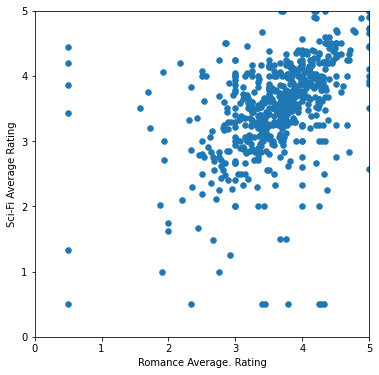

In [16]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,6))
ax = plt.axes()
ax.scatter(user_genre_ratings['Romance_avg_rating'], user_genre_ratings['Sci-Fi_avg_rating'], s=30)# Plot the scatterplot
ax.set_xlim(0, 5)
ax.set_ylim(0, 5)
ax.set_xlabel("Romance Average. Rating")
ax.set_ylabel("Sci-Fi Average Rating")
plt.show()

We can see that there is a broadly positive correlation between ratings for Romance and Sci-Fi (i.e. users who rate Romance highly also tend to rate Sci-Fi highly).

We can compute the correlation coefficient between the average user ratings for the two genres:

In [17]:
corr_coeff = user_genre_ratings['Romance_avg_rating'].corr(user_genre_ratings['Sci-Fi_avg_rating'])
print('The correlation coefficient between average user ratings for romance and sci-fi is:',round(corr_coeff,1))

The correlation coefficient between average user ratings for romance and sci-fi is: 0.4


Also print the mean ratings for each genre:

In [18]:
print('Mean user average rating for romance movies:',round(user_genre_ratings['Romance_avg_rating'].mean(),1))
print('Mean user average rating for sci-fi movies:',round(user_genre_ratings['Sci-Fi_avg_rating'].mean(),1))

Mean user average rating for romance movies: 3.6
Mean user average rating for sci-fi movies: 3.5


## K-Means Clustering by genre preference
---

We will now use the K-Means clustering algorithm to separate the users into two subgroups by genre perference. 

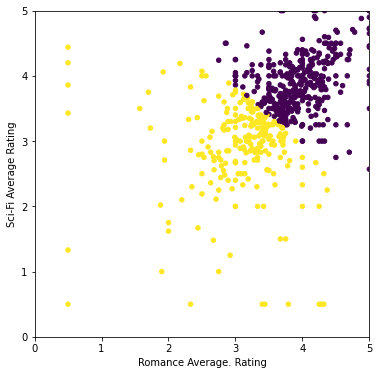

In [19]:
from sklearn.cluster import KMeans

# First we need to turn our input data into an array
X = user_genre_ratings[['Romance_avg_rating','Sci-Fi_avg_rating']].values
#print(type(X))

# Import KMeans
k=2 # Find 2 clusters
kmeans_2 = KMeans(n_clusters=k,random_state=2) 
predictions_2 = kmeans_2.fit_predict(X) # Use fit_predict to cluster the users into one of two clusters and output the predictions
# predictions_2 contains a 0 or 1 for each row in the df denoting which cluster the user belongs to
#print(len(predictions_2))
#print(predictions_2)
#print(type(predictions_2))

fig = plt.figure(figsize=(6,6))
ax = plt.axes()
ax.scatter(user_genre_ratings['Romance_avg_rating'],user_genre_ratings['Sci-Fi_avg_rating'],c=predictions_2,cmap='viridis',s=20)
ax.set_xlim(0, 5)
ax.set_ylim(0, 5)
ax.set_xlabel("Romance Average. Rating")
ax.set_ylabel("Sci-Fi Average Rating")
plt.show()

Print out the two cluster centres:

In [20]:
print(kmeans_2.cluster_centers_)

[[3.95192612 3.88448549]
 [3.07073593 2.88909091]]


In one cluster users rate both romance and sci-fi highly:

In [21]:
print('Cluster 1 has mean Romance and Sci-Fi ratings',round(kmeans_2.cluster_centers_[0][0],1),'and',
      round(kmeans_2.cluster_centers_[0][1],1),', respectively')

Cluster 1 has mean Romance and Sci-Fi ratings 4.0 and 3.9 , respectively


In the other cluster users rate romance and scifi as "average":

In [22]:
print('Cluster 2 has mean Romance and Sci-Fi ratings',round(kmeans_2.cluster_centers_[1][0],1),'and',
      round(kmeans_2.cluster_centers_[1][1],1),', respectively.')

Cluster 2 has mean Romance and Sci-Fi ratings 3.1 and 2.9 , respectively.


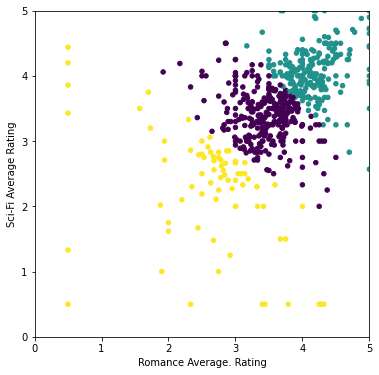

In [23]:
# Create an instance of KMeans to find three clusters
k=3
kmeans_3 = KMeans(n_clusters=k,random_state=3)
predictions_3 = kmeans_3.fit_predict(X) # Use fit_predict to cluster the dataset
fig = plt.figure(figsize=(6,6))
ax = plt.axes()
ax.scatter(user_genre_ratings['Romance_avg_rating'],user_genre_ratings['Sci-Fi_avg_rating'],c=predictions_3,cmap='viridis',s=20)
ax.set_xlim(0, 5)
ax.set_ylim(0, 5)
ax.set_xlabel("Romance Average. Rating")
ax.set_ylabel("Sci-Fi Average Rating")
plt.show()

Print out the cluster centres:

In [24]:
print(kmeans_3.cluster_centers_)

[[3.44911475 3.38429508]
 [4.17034934 4.0769869 ]
 [2.63328947 2.28631579]]


Now we have users clustered into groups that rate both romance and sci-fi as: "high", "just below average" and "just above average". 

We are not seeing clusters for people who like, for example, sci-fi but not romance and vice versa. 

How about if we have 4 clusters? How does the picture look then?

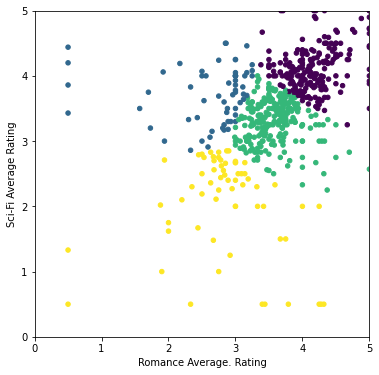

In [25]:
# Create an instance of KMeans to find four clusters
k=4
kmeans_4 = KMeans(n_clusters=k,random_state=1)
predictions_4 = kmeans_4.fit_predict(X) # Use fit_predict to cluster the dataset
fig = plt.figure(figsize=(6,6))
ax = plt.axes()
ax.scatter(user_genre_ratings['Romance_avg_rating'],user_genre_ratings['Sci-Fi_avg_rating'],c=predictions_4,cmap='viridis',s=20)
ax.set_xlim(0, 5)
ax.set_ylim(0, 5)
ax.set_xlabel("Romance Average. Rating")
ax.set_ylabel("Sci-Fi Average Rating")
plt.show()

Now we start to see clusters where users rate one genre more highly than the other.

Print out the cluster centres:

In [26]:
print(kmeans_4.cluster_centers_)

[[4.16126697 4.10855204]
 [2.62129032 3.71935484]
 [3.58121673 3.30718631]
 [2.8609375  2.0503125 ]]


Now we have groups for users as follows:

1. high average ratings for romance and sci-fi
2. below average for romance and above average for sci-fi
3. above average for romance and sci-fi
4. below average for romance and sci-fi

So now we have a more nuanced clustering picture that picks out users who prefer one genre over another. 

<div class="alert alert-block alert-info"><b>Exercise 2:</b><br>Let's now add an extra dimension. Repeat the same clustering for the genres "Romance", "Sci-Fi" and "Action" and generate a 3D plot showing users belonging to different clusters in different colors. You can choose whatever small value for k you want. <br><br><i>Hint: Check out <a href="https://matplotlib.org/stable/gallery/mplot3d/subplot3d.html">this example</a> in matplotlib for generating 3D plots.</i></div>

In [27]:
### Exercise 2: Example Solution ###



## Clustering using all genres
---

Now let's find clusters using all the genres.

But before we continue we need to consider whether it would make sense to "standardize" the ratings to the mean rating for each user.

What if some users have a tendency to rate all movies higher, and others to rate all movies lower? Then it will be harder to pick out individual users' preferences.

Let's plot the average ratings by user:

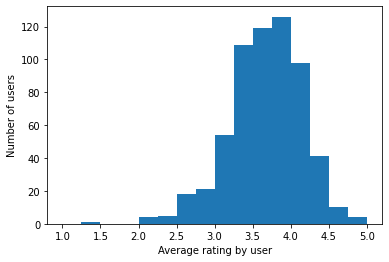

In [28]:
import numpy as np

ratings_avg_user = ratings.groupby(['userId'])['rating'].mean()

binbreaks = np.arange(1,5.25,0.25)

plt.hist(ratings_avg_user,bins=binbreaks)
plt.xlabel('Average rating by user')
plt.ylabel('Number of users')
plt.show()

There is quite a wide range in the average ratings score by user.

We could improve on the clustering analysis by subtracting the mean rating over all genres for each user. We then reduce the bias caused by different users generally rating movies higher or lower.

In [29]:
# Create a df with the average user rating by genre for all genres

# First get the column names for each genre in the df
column_names = []
for genre in genre_names_new:
    column_names.append(genre+'_avg_rating')

# Pass ratings, movies, genre_names & column_names to get_user_genre_ratings
# Returns a df with average user rating for each genre
user_ratings_genres_all = get_user_genre_ratings(ratings, movies_genres, genre_names_new, column_names)

user_ratings_genres_all.head()

,Adventure_avg_rating,Animation_avg_rating,Children_avg_rating,Comedy_avg_rating,Fantasy_avg_rating,Romance_avg_rating,Drama_avg_rating,Action_avg_rating,Crime_avg_rating,Thriller_avg_rating,Horror_avg_rating,Mystery_avg_rating,Sci-Fi_avg_rating,War_avg_rating,Musical_avg_rating,Documentary_avg_rating,IMAX_avg_rating,Western_avg_rating,Film-Noir_avg_rating
1,4.39,4.69,4.55,4.28,4.30,4.31,4.53,4.32,4.36,4.15,3.47,4.17,4.22,4.50,4.68,NaN,NaN,4.29,5.0
2,4.17,NaN,NaN,4.00,NaN,4.50,3.88,3.95,3.80,3.70,3.00,4.00,3.88,4.50,NaN,4.33,3.75,3.50,NaN
3,2.73,0.50,0.50,1.00,3.38,0.50,0.75,3.57,0.50,4.14,4.69,5.00,4.20,0.50,0.50,NaN,NaN,NaN,NaN
4,3.66,4.00,3.80,3.51,3.68,3.38,3.48,3.32,3.81,3.55,4.25,3.48,2.83,3.57,4.00,4.00,3.00,3.80,4.0
5,3.25,4.33,4.11,3.47,4.14,3.09,3.80,3.11,3.83,3.56,3.00,4.00,2.50,3.33,4.40,NaN,3.67,3.00,NaN


In [30]:
user_ratings_genres_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 610 entries, 1 to 610
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Adventure_avg_rating    606 non-null    float64
 1   Animation_avg_rating    527 non-null    float64
 2   Children_avg_rating     559 non-null    float64
 3   Comedy_avg_rating       609 non-null    float64
 4   Fantasy_avg_rating      583 non-null    float64
 5   Romance_avg_rating      606 non-null    float64
 6   Drama_avg_rating        610 non-null    float64
 7   Action_avg_rating       608 non-null    float64
 8   Crime_avg_rating        603 non-null    float64
 9   Thriller_avg_rating     609 non-null    float64
 10  Horror_avg_rating       535 non-null    float64
 11  Mystery_avg_rating      580 non-null    float64
 12  Sci-Fi_avg_rating       605 non-null    float64
 13  War_avg_rating          551 non-null    float64
 14  Musical_avg_rating      470 non-null    float64

In [31]:
# For users where there are no ratings for some genres replace NaN with 0.5 (the lowest rating) since
# we can "reasonably" assume that if a user never watches a certain genre then they don't like it
user_ratings_genres_all.fillna(0.5,inplace=True)
#user_ratings_genres_all.dropna(inplace=True)

# Create a new df with adjusted (standardized) average ratings (i.e. with the mean rating for each user subracted)

# Get mean rating for each user across all genres
user_ratings_genres_all['mean'] = user_ratings_genres_all.iloc[:,:].mean(axis=1) # Get the mean across columns (axis=1) for all rows
# Subtract the mean to create a new df with adjusted ratings
user_ratings_genres_all_adj = user_ratings_genres_all.subtract(user_ratings_genres_all['mean'],axis=0)
user_ratings_genres_all_adj = user_ratings_genres_all_adj.drop(['mean'],axis=1)

# Change the column names
column_names_adj = []
for genre in genre_names_new:
    column_names_adj.append(genre+'_avg_rating_adj')

user_ratings_genres_all_adj.columns = column_names_adj
user_ratings_genres_all_adj.head()

,Adventure_avg_rating_adj,Animation_avg_rating_adj,Children_avg_rating_adj,Comedy_avg_rating_adj,Fantasy_avg_rating_adj,Romance_avg_rating_adj,Drama_avg_rating_adj,Action_avg_rating_adj,Crime_avg_rating_adj,Thriller_avg_rating_adj,Horror_avg_rating_adj,Mystery_avg_rating_adj,Sci-Fi_avg_rating_adj,War_avg_rating_adj,Musical_avg_rating_adj,Documentary_avg_rating_adj,IMAX_avg_rating_adj,Western_avg_rating_adj,Film-Noir_avg_rating_adj
1,0.431579,0.731579,0.591579,0.321579,0.341579,0.351579,0.571579,0.361579,0.401579,0.191579,-0.488421,0.211579,0.261579,0.541579,0.721579,-3.458421,-3.458421,0.331579,1.041579
2,1.145789,-2.524211,-2.524211,0.975789,-2.524211,1.475789,0.855789,0.925789,0.775789,0.675789,-0.024211,0.975789,0.855789,1.475789,-2.524211,1.305789,0.725789,0.475789,-2.524211
3,0.916316,-1.313684,-1.313684,-0.813684,1.566316,-1.313684,-1.063684,1.756316,-1.313684,2.326316,2.876316,3.186316,2.386316,-1.313684,-1.313684,-1.313684,-1.313684,-1.313684,-1.313684
4,0.022105,0.362105,0.162105,-0.127895,0.042105,-0.257895,-0.157895,-0.317895,0.172105,-0.087895,0.612105,-0.157895,-0.807895,-0.067895,0.362105,0.362105,-0.637895,0.162105,0.362105
5,0.008421,1.088421,0.868421,0.228421,0.898421,-0.151579,0.558421,-0.131579,0.588421,0.318421,-0.241579,0.758421,-0.741579,0.088421,1.158421,-2.741579,0.428421,-0.241579,-2.741579


In [32]:
# Turn the dataset into a list
X_genres_all = user_ratings_genres_all_adj[column_names_adj].values

# Create an instance of KMeans to find k clusters
k=9 # Choose 9 clusters
kmeans_genres_all = KMeans(n_clusters=k,random_state=2)

#Use fit_predict to cluster the dataset
predictions_genres_all = kmeans_genres_all.fit_predict(X_genres_all)

# Add a column to the df for cluster membership
user_ratings_genres_all_adj['Cluster'] = predictions_genres_all

user_ratings_genres_all_adj.head()

,Adventure_avg_rating_adj,Animation_avg_rating_adj,Children_avg_rating_adj,Comedy_avg_rating_adj,Fantasy_avg_rating_adj,Romance_avg_rating_adj,Drama_avg_rating_adj,Action_avg_rating_adj,Crime_avg_rating_adj,Thriller_avg_rating_adj,Horror_avg_rating_adj,Mystery_avg_rating_adj,Sci-Fi_avg_rating_adj,War_avg_rating_adj,Musical_avg_rating_adj,Documentary_avg_rating_adj,IMAX_avg_rating_adj,Western_avg_rating_adj,Film-Noir_avg_rating_adj,Cluster
1,0.431579,0.731579,0.591579,0.321579,0.341579,0.351579,0.571579,0.361579,0.401579,0.191579,-0.488421,0.211579,0.261579,0.541579,0.721579,-3.458421,-3.458421,0.331579,1.041579,8
2,1.145789,-2.524211,-2.524211,0.975789,-2.524211,1.475789,0.855789,0.925789,0.775789,0.675789,-0.024211,0.975789,0.855789,1.475789,-2.524211,1.305789,0.725789,0.475789,-2.524211,4
3,0.916316,-1.313684,-1.313684,-0.813684,1.566316,-1.313684,-1.063684,1.756316,-1.313684,2.326316,2.876316,3.186316,2.386316,-1.313684,-1.313684,-1.313684,-1.313684,-1.313684,-1.313684,6
4,0.022105,0.362105,0.162105,-0.127895,0.042105,-0.257895,-0.157895,-0.317895,0.172105,-0.087895,0.612105,-0.157895,-0.807895,-0.067895,0.362105,0.362105,-0.637895,0.162105,0.362105,0
5,0.008421,1.088421,0.868421,0.228421,0.898421,-0.151579,0.558421,-0.131579,0.588421,0.318421,-0.241579,0.758421,-0.741579,0.088421,1.158421,-2.741579,0.428421,-0.241579,-2.741579,2


How many users belong to each cluster?

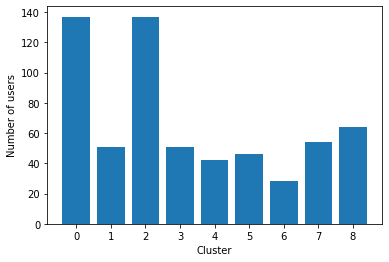

In [33]:
cluster_members = [] # List for number of users in each cluster
cluster_labels = [] # List for cluster labels (0,1,..,k-1)
for i in range(0,k):
    cluster_labels.append(str(i)) # Make the cluster labels list
    num = 0
    for j in range(0,len(user_ratings_genres_all_adj)): # Loop through the df
        if user_ratings_genres_all_adj['Cluster'].iloc[j] == i: # If the user belongs to the cluster increase the cluster membership by 1
            num = num + 1
    cluster_members.append(num)
    
plt.bar(cluster_labels,cluster_members)
#print(user_ratings_genres_all_adj['Cluster'].unique())
plt.xlabel('Cluster')
plt.ylabel('Number of users')
plt.show()
#print(cluster_members)

We can see that cluster membership is reasonably well spread across the clusters.

Now let's see how movie genre preference varies across clusters:

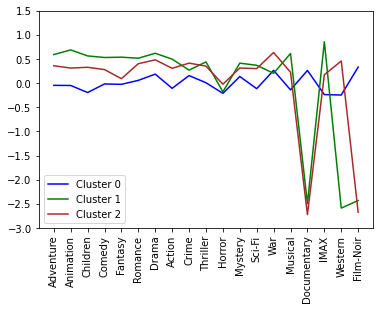

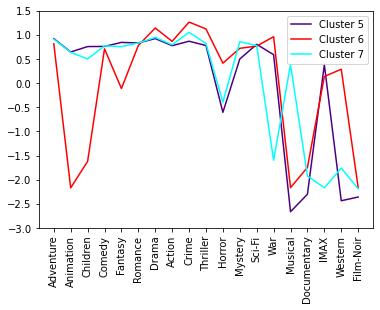

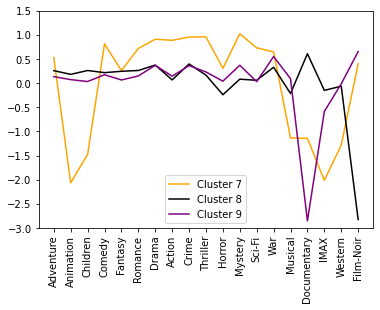

In [34]:
# Plot the cluster centres for each cluster
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = plt.axes()
line1, = ax1.plot(column_names,kmeans_genres_all.cluster_centers_[0],color='blue',label='Cluster 0')
line2, = ax1.plot(column_names,kmeans_genres_all.cluster_centers_[1],color='green',label='Cluster 1')
line3, = ax1.plot(column_names,kmeans_genres_all.cluster_centers_[2],color='brown',label='Cluster 2')
plt.ylim([-3,1.5])
plt.xticks(range(len(genre_names_new)), genre_names_new, rotation='vertical')
plt.legend(handles=[line1, line2, line3])
plt.show()

fig = plt.figure()
ax2 = plt.axes()
line1, = ax2.plot(column_names,kmeans_genres_all.cluster_centers_[3],color='indigo',label='Cluster 5')
line2, = ax2.plot(column_names,kmeans_genres_all.cluster_centers_[4],color='red',label='Cluster 6')
line3, = ax2.plot(column_names,kmeans_genres_all.cluster_centers_[5],color='cyan',label='Cluster 7')
plt.ylim([-3,1.5])
plt.xticks(range(len(genre_names_new)), genre_names_new, rotation='vertical')
plt.legend(handles=[line1, line2, line3])
plt.show()

fig = plt.figure()
ax3 = plt.axes()
line1, = ax3.plot(column_names,kmeans_genres_all.cluster_centers_[6],color='orange',label='Cluster 7')
line2, = ax3.plot(column_names,kmeans_genres_all.cluster_centers_[7],color='black',label='Cluster 8')
line3, = ax3.plot(column_names,kmeans_genres_all.cluster_centers_[8],color='purple',label='Cluster 9')
plt.ylim([-3,1.5])
plt.xticks(range(len(genre_names_new)), genre_names_new, rotation='vertical')
plt.legend(handles=[line1, line2, line3])
plt.show()

The plots above are useful to show how different clusters contain users with differing preferences with regards to film genre.

We can see that in clusters 1 and 2, for example, both rate documentaries and film-noir low, but while cluster 1 rates westerns low, cluster 2 rates them above average.

Cluster 6 rates animation and musical genres low and war films high, whereas cluster 7 rates animation and musical genres high and war films low.

What is the optimal number of clusters to use? This is not simple to answer. We could decide how many clusters we require, or we could use a clustering evaluation metric, such as the Silhouette Coefficient. 

The Silhouette Coefficient scores the clustering pattern highly if groups are compact and well-separated. Refer to the [lecture slides](https://moodle.essex.ac.uk/pluginfile.php/1771417/mod_resource/content/1/MA336_ML_Lectures2and3.pdf) for a discussion of clustering evaluation metrics. 

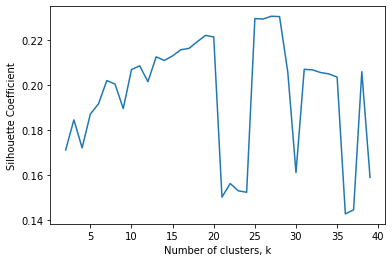

In [35]:
from sklearn.metrics import silhouette_score
import numpy as np

def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k,random_state=1).fit(data)
    predictions = kmeans.predict(data) # Or use kmeans.labels_ 
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

possible_k_values = range(2,40)
errors_per_k = [clustering_errors(k, X_genres_all) for k in possible_k_values]# Plot each value of k vs. the silhouette score at that value

fig = plt.figure()
ax = plt.axes()
ax.plot(possible_k_values, errors_per_k)
plt.xlabel('Number of clusters, k')
plt.ylabel('Silhouette Coefficient')
plt.show()

The Silhouette Coefficient becomes unstable for k above about 20 (try different random_state values in `KMeans`). Based on this plot we might choose a value for k around 18. 

## Clustering based on individual movies
---

So far we have looked at grouping individuals by genre preferences. These clusters can then be used to recommend movies based on genre. For example, an individual belonging to a cluster whose members like romance and action movies but not sci-fi would be recommended movies from the first two genres.

But suppose instead we want to build a recommender that suggests specific movie titles to viewers? Then we need to allocate individuals to clusters in which the features are movie titles rather than genre average ratings. Viewers belong to a group in which the movies they have rated highly have also been rated highly by other members of the group (and similarly for low ratings). Viewers can then be recommended movies they have not yet watched but that other members of the group have, on average, rated highly.

Now we need movie titles to be the column headings, instead of genre average ratings, but with viewers still in the rows. First we merge the `ratings` and `movies` dataframes and then use `pivot_table()` to put users in rows and movies titles in columns (and with values being ratings).

In [36]:
# Merge the ratings and movie dataframes on movieId
ratings_title = pd.merge(ratings, movies[['movieId', 'title']], on='movieId' )

# "Pivot" the dataframe so rows are users and columns are movie ratings
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')

# Check the dimensions of the new dataframe
print('Dataframe dimensions: ', user_movie_ratings.shape)

# Print outside the first few rows of the df
user_movie_ratings.head()

Dataframe dimensions:  (610, 9719)


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As we can see above, most entries in the merged dataframe contain "NaN" values because most users have rated only a small fraction of the movies. A dataframe in which most entries contain zero or NaN values is known as "sparse". Sparse datasets can present important challenges to training machine learning algorithms. However, some actions can be taken to overcome those (see [this article](https://www.kdnuggets.com/2021/01/sparse-features-machine-learning-models.html)). 

In our case we see that some movies are more popular than others, therefore they have more ratings among the users. The approach we follow here is to use only the movies with the most number of ratings (most popular) of the dataset:

In [37]:
def subset_by_rating_density(user_movie_ratings, max_number_of_movies, max_number_of_users):
    """
    Creates a subset of most rated movies and users who rate the most
    
    Arguments
    ---------
    user_movie_ratings : Pandas dataframe with all users & movie ratings 
    max_number_of_movies : Top number of movies according to number of ratings 
    max_number_of_users : Top number of users according to movies rated. 
    
    Outputs
    -------
    A new dataframe with subset of users (rows) and movies ratings (columns)
    """
    
    # Filter movies by number of ratings
    
    # Count number of ratings received for each movie and append a row at the end containing the counts
    user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
    # Sort columns according to last row numbers
    user_movie_ratings_sorted = user_movie_ratings.sort_values(len(user_movie_ratings)-1, axis=1, ascending=False)
    # Delete the last row
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)
    # Slice the columns to the desired max_number_of_movies
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies].copy()
    
    # Filter users by number of rated movies
    
    # Create new colum with the number of not null cases
    most_rated_movies["user_num_ratings"] = most_rated_movies.notnull().sum(axis=1) # Sum over columns
    # Sort rows by the value of this column
    most_rated_movies_sorted = most_rated_movies.sort_values(by="user_num_ratings", axis=0, ascending=False)
    # Delete the column
    del most_rated_movies_sorted["user_num_ratings"]
    # Slice rows to the desired max_number_of_users
    finaldf = most_rated_movies_sorted.iloc[:max_number_of_users, :].copy()
    
    return(finaldf)

Let's show how this function works for the top 15 rated titles and the 25 users who have rated the most number of movies:

In [38]:
max_movies = 15 # Number of top rated movies
max_users = 25 # Number of "top" users (users who rate the most movies)

# Get a subset of the user_movie_ratings df
subset = subset_by_rating_density(user_movie_ratings, max_movies, max_users)

# View the df
subset

title,Forrest Gump (1994),"Shawshank Redemption, The (1994)",Pulp Fiction (1994),"Silence of the Lambs, The (1991)","Matrix, The (1999)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),Braveheart (1995),Terminator 2: Judgment Day (1991),Schindler's List (1993),Fight Club (1999),Toy Story (1995),Star Wars: Episode V - The Empire Strikes Back (1980),"Usual Suspects, The (1995)",American Beauty (1999)
609,3.0,3.0,5.0,4.5,5.0,5.0,5.0,4.5,5.0,3.5,5.0,5.0,5.0,4.0,3.5
473,3.0,5.0,4.0,4.5,4.5,4.0,4.5,3.0,4.0,5.0,4.0,4.0,5.0,4.0,3.5
67,3.5,3.0,2.0,3.5,4.5,5.0,3.5,2.5,3.5,4.0,2.5,2.5,5.0,3.0,5.0
181,5.0,4.5,5.0,4.5,5.0,3.5,3.5,3.5,2.0,4.0,5.0,4.0,3.0,4.5,5.0
246,5.0,4.5,4.0,4.0,3.5,4.0,4.5,4.0,3.5,4.0,5.0,5.0,4.5,5.0,4.0
248,4.5,4.5,4.0,4.0,5.0,5.0,4.0,5.0,4.0,4.5,5.0,4.0,5.0,4.0,4.5
253,5.0,4.5,5.0,4.0,5.0,4.0,4.0,4.0,4.0,5.0,5.0,4.5,4.0,4.5,5.0
273,4.5,4.5,5.0,4.0,4.0,3.0,3.5,4.5,4.5,4.0,5.0,4.0,4.5,4.0,5.0
306,4.0,4.5,4.5,4.5,3.5,3.5,3.5,3.5,2.5,4.5,4.0,4.0,3.0,4.5,4.0
390,5.0,5.0,5.0,3.0,5.0,5.0,2.0,5.0,4.0,5.0,4.0,3.0,5.0,4.0,4.0


Subsetting the dataframe now shows higher density of ratings i.e. much fewer NaNs.

Now let's plot a heatmap for this subset. The heatmap gives a visual representation of the rating values of the top-rated movies by user.

First define a function to plot the heatmap:

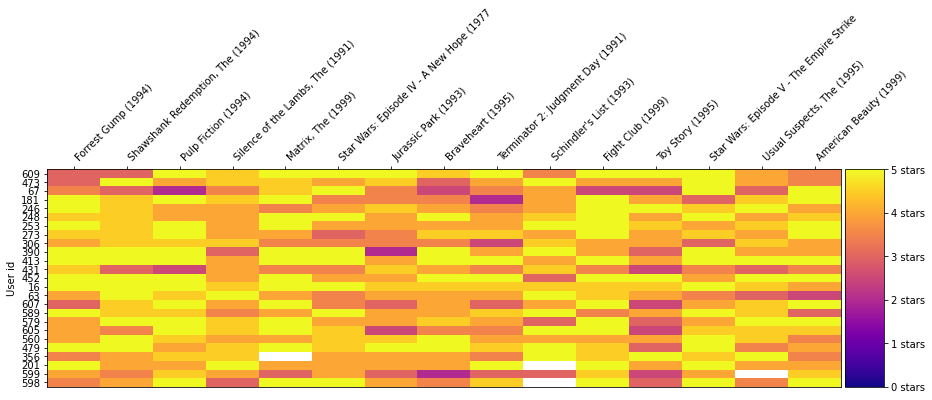

In [39]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create the movies heatmap
def draw_movies_heatmap(user_movie_ratings, cmap_name="plasma", axis_labels=True, figsize=(15,4)):
    """
    Plots the 
    """
    # Create the figure
    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    
    # Draw heatmap
    heatmap = ax.imshow(user_movie_ratings, cmap=plt.get_cmap(cmap_name), interpolation='nearest', vmin=0, vmax=5, aspect='auto')
    
    # Deal with axes
    if axis_labels:
        # Set X and Y axes labels
        ax.set_yticks(np.arange(user_movie_ratings.shape[0]) , minor=False)
        ax.set_xticks(np.arange(user_movie_ratings.shape[1]) , minor=False)
        ax.xaxis.tick_top()
        labels = user_movie_ratings.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(user_movie_ratings.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=45, ha='left')
    else:
        # Remove X and Y axis labels
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    ax.grid(False)
    ax.set_ylabel('User id')
    
    # Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    
    # Format the colorbar on the right
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])
    
    plt.show()
    
# Plot the heatmap for the subset above    
draw_movies_heatmap(subset)

This way of showing user ratings allows us to find patterns very quickly. For example, "The Shawshank Redemtion" and "Pulp Fiction" have very high ratings. Also, rows with similiar color patterns to each other can identify users with similar taste. Users that have a similar colour across films tend to give a similar rating to all movies they have watched, in comparison to rows where the colour changes across entries, showing the viewer gives a wider range of ratings.

## Building the movie recommender

Now we've seen how to create a subset of the "user_movie_ratings" dataframe, let's create a subset to use for our movie recommender.

We'll use the top 1000 most-rated movies and include all 610 users in the dataframe ("top_1000_movies").

In [40]:
# Create a subset with all users (610) and only the most-rated 1000 movies
max_movies = 1000 # Number of top rated movies
max_users = 610 # Number of users

top_1000_movies = subset_by_rating_density(user_movie_ratings, max_movies, max_users)

# View the df:
top_1000_movies.head()

title,Forrest Gump (1994),"Shawshank Redemption, The (1994)",Pulp Fiction (1994),"Silence of the Lambs, The (1991)","Matrix, The (1999)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),Braveheart (1995),Terminator 2: Judgment Day (1991),Schindler's List (1993),...,Scary Movie 2 (2001),About Schmidt (2002),21 Jump Street (2012),"Cider House Rules, The (1999)",Death Proof (2007),Moonraker (1979),"Virgin Suicides, The (1999)",¡Three Amigos! (1986),Waking Ned Devine (a.k.a. Waking Ned) (1998),Jacob's Ladder (1990)
413,5.0,5.0,5.0,4.0,5.0,5.0,4.0,5.0,5.0,4.0,...,2.0,4.0,NaN,4.0,3.5,3.0,4.0,3.0,NaN,3.0
598,3.5,4.0,5.0,3.0,5.0,5.0,4.0,3.5,4.5,NaN,...,1.5,1.5,2.5,3.0,3.5,NaN,2.5,2.5,2.5,4.0
67,3.5,3.0,2.0,3.5,4.5,5.0,3.5,2.5,3.5,4.0,...,2.0,NaN,5.0,NaN,NaN,2.0,3.0,4.0,NaN,2.0
273,4.5,4.5,5.0,4.0,4.0,3.0,3.5,4.5,4.5,4.0,...,3.0,NaN,NaN,NaN,1.5,NaN,NaN,NaN,NaN,4.0
473,3.0,5.0,4.0,4.5,4.5,4.0,4.5,3.0,4.0,5.0,...,NaN,3.5,NaN,3.0,NaN,NaN,4.0,3.0,NaN,NaN


## Run the KMeans clustering algorithm
---

We can see that although we have chosen only the top 1000 movies, the dataframe still contains many NaN entries.  

The `KMeans()` function cannot operate with sparse matrices (with lots of Nan values). So, we need to format the dataframe with lots of Nans to a `csr_matrix` from `scipy` package. Here some pointers: (https://towardsdatascience.com/working-with-sparse-data-sets-in-pandas-and-sklearn-d26c1cfbe067)

In [41]:
from scipy.sparse import csr_matrix

# Convert to a pandas sparse dataframe type
df_sparsed = top_1000_movies.astype(pd.SparseDtype("float", np.nan))

# Convert to scipy sparse csr_matrix
sparse_ratings = csr_matrix(df_sparsed.sparse.to_coo()) # Contains only non-null entries 
#df_sparsed.head() # Checking
#print(sparse_ratings[5,0:15]) # Checking

Run the `KMeans` algorithm using "sparse_ratings" and 20 clusters:

In [42]:
# Specifiy number of clusters to use
k = 20

# Let KMeans find the clusters in movie title space (clusters contain users with similar preferences in movie titles)
kmeans_top_1000_movies = KMeans(n_clusters=k,random_state=2).fit(sparse_ratings)

# Get the cluster each user has been assigned
predictions = kmeans_top_1000_movies.predict(sparse_ratings) # Alternatively, use kmeans_top_1000_movies.labels_
#print(predictions[0:10]) # Checking

# Create a new df called "clustered" that includes a column with the cluster each user has been assigned
# First set "clustered" as the df containing the top 1000 most-rated movies (i.e. "top_1000_movies" df)
# Also reset index on "top_1000_movies" (index currently userid) and rename the index column as the userid
clustered = top_1000_movies.reset_index() # set "clustered" equal to "top_1000_movies" and reset index
clustered = clustered.rename(columns={"index" : "userid"}) # rename index column as userid (we will need this for the recommender)
clustered["cluster"] = predictions # Add a column called *cluster* that contains the cluster assigned to the user

# Look at the new dataframe with users assigned to clusters
clustered.head(10)

title,userid,Forrest Gump (1994),"Shawshank Redemption, The (1994)",Pulp Fiction (1994),"Silence of the Lambs, The (1991)","Matrix, The (1999)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),Braveheart (1995),Terminator 2: Judgment Day (1991),...,About Schmidt (2002),21 Jump Street (2012),"Cider House Rules, The (1999)",Death Proof (2007),Moonraker (1979),"Virgin Suicides, The (1999)",¡Three Amigos! (1986),Waking Ned Devine (a.k.a. Waking Ned) (1998),Jacob's Ladder (1990),cluster
0,413,5.0,5.0,5.0,4.0,5.0,5.0,4.0,5.0,5.0,...,4.0,NaN,4.0,3.5,3.0,4.0,3.0,NaN,3.0,14
1,598,3.5,4.0,5.0,3.0,5.0,5.0,4.0,3.5,4.5,...,1.5,2.5,3.0,3.5,NaN,2.5,2.5,2.5,4.0,14
2,67,3.5,3.0,2.0,3.5,4.5,5.0,3.5,2.5,3.5,...,NaN,5.0,NaN,NaN,2.0,3.0,4.0,NaN,2.0,14
3,273,4.5,4.5,5.0,4.0,4.0,3.0,3.5,4.5,4.5,...,NaN,NaN,NaN,1.5,NaN,NaN,NaN,NaN,4.0,5
4,473,3.0,5.0,4.0,4.5,4.5,4.0,4.5,3.0,4.0,...,3.5,NaN,3.0,NaN,NaN,4.0,3.0,NaN,NaN,2
5,447,3.0,NaN,5.0,5.0,2.0,5.0,3.0,NaN,3.0,...,3.5,4.5,NaN,NaN,3.0,NaN,3.0,NaN,NaN,14
6,479,5.0,5.0,4.0,4.5,5.0,4.5,5.0,5.0,4.5,...,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,5
7,379,5.0,3.0,5.0,5.0,4.5,5.0,5.0,4.0,5.0,...,NaN,NaN,NaN,3.0,4.0,NaN,NaN,NaN,NaN,4
8,607,3.0,4.5,5.0,4.0,5.0,3.5,3.0,4.0,3.0,...,3.0,NaN,4.5,NaN,NaN,NaN,NaN,NaN,NaN,5
9,589,5.0,4.5,4.5,3.5,4.0,5.0,4.0,4.0,4.5,...,NaN,NaN,3.5,NaN,2.5,NaN,NaN,NaN,NaN,2


In [43]:
# Check *cluster* contains 20 subgroups:
print('The dataset is divided into',len(clustered.cluster.unique()),'subgroups.')

The dataset is divided into 20 subgroups.


<div class="alert alert-block alert-info"><b>Exercise 3:</b><br> 

Use this last dataframe "clustered" to build a movie recommender. The movie recommender should be based on the highest rated movies in the cluster assigned to the user. Only recommend movies that the user hasn't watched (rated) yet. Create a function that takes a user id and the clustered data frame as the inputs. The function should return the top 5 recommended movies alongside the average rating of the movie according to the other users in the same cluster.</div>

In [44]:
### Exercise 3: Solution ###



---
<div style="text-align: right ;font-size: small; color: gray"> Notebook by <a href="http://mariogutierrezroig.net">Mario Gutiérrez-Roig</a> and <a href="https://www.essex.ac.uk/people/voigt40704/lisa-voigt">Lisa Voigt</a>, Lecturers in Data Science and Statistics at the University of Essex <a href="http://creativecommons.org/licenses/by-sa/4.0/" rel="license"><img src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" alt="Licencia de Creative Commons" hspace="10" align="right"></a></div>